In [20]:
import rasterio
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

%matplotlib inline

Coordinate Reference System: EPSG:4326
Transform: | 0.00, 0.00, 32.00|
| 0.00,-0.00, 40.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=31.999583333333334, bottom=38.999583333333334, right=33.000416666666666, top=40.000416666666666)


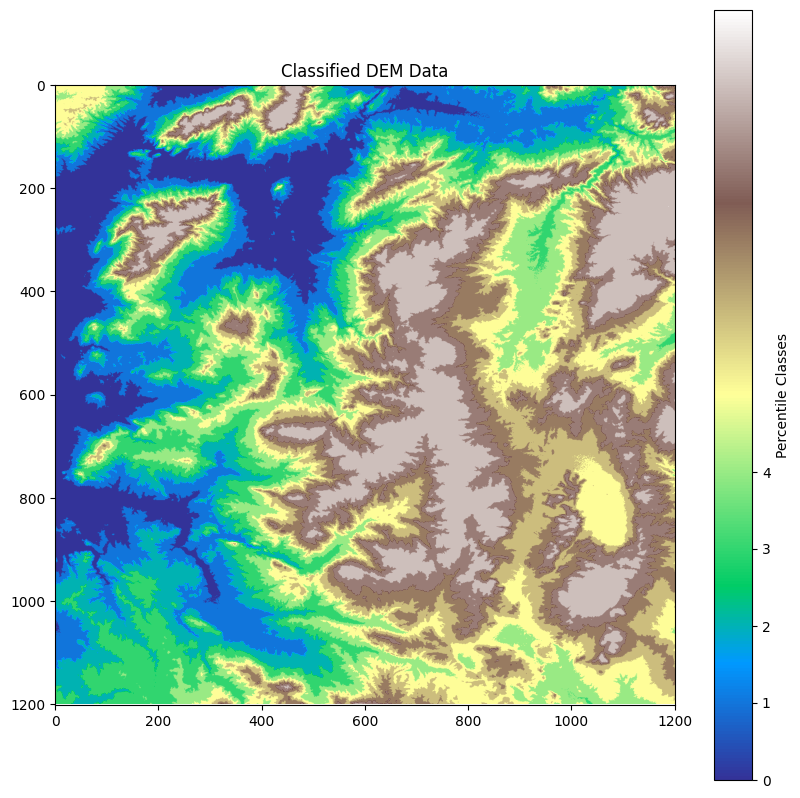

In [18]:

# Function to classify the elevation data into percentiles using CuPy
def classify_percentiles_gpu(data, num_classes=10):
    # Transfer data to GPU
    data_gpu = cp.asarray(data)
    
    # Compute percentiles on the GPU
    percentiles_gpu = cp.percentile(data_gpu, cp.linspace(0, 100, num_classes + 1))
    
    # Classify data based on percentiles
    classified_gpu = cp.digitize(data_gpu, percentiles_gpu) - 1
    
    # Transfer the result back to CPU
    return cp.asnumpy(classified_gpu)

# Using SRTM Void Filled 3arc, South-West Ankara - Coordinates: 39 , 32
# Data from https://earthexplorer.usgs.gov/
raster_file = 'n39_e032_3arc_v2.tif'

# Open the raster file
with rasterio.open(raster_file) as dataset:
    # Read the raster data as NumPy array
    raster_data = dataset.read(1)
    crs = dataset.crs
    transform = dataset.transform
    print(f'Coordinate Reference System: {crs}')
    print(f'Transform: {transform}')
    bounds = dataset.bounds
    print(f'Bounds: {bounds}')

# Convert NumPy array to CuPy array for GPU processing
raster_data_gpu = cp.asarray(raster_data)

# Perform operations on the GPU (example: calculate mean)
mean_value_gpu = cp.mean(raster_data_gpu)

# Perform classification into percentiles using GPU
classified_data_gpu = classify_percentiles_gpu(raster_data)

# Plot the classified DEM data
plt.figure(figsize=(10, 10))
plt.imshow(classified_data_gpu, cmap='terrain')
plt.title('Classified DEM Data')
plt.colorbar(ticks=range(5), label='Percentile Classes')

plt.show()


Coordinate Reference System: EPSG:4326
Transform: | 0.00, 0.00, 32.00|
| 0.00,-0.00, 40.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=31.999583333333334, bottom=38.999583333333334, right=33.000416666666666, top=40.000416666666666)


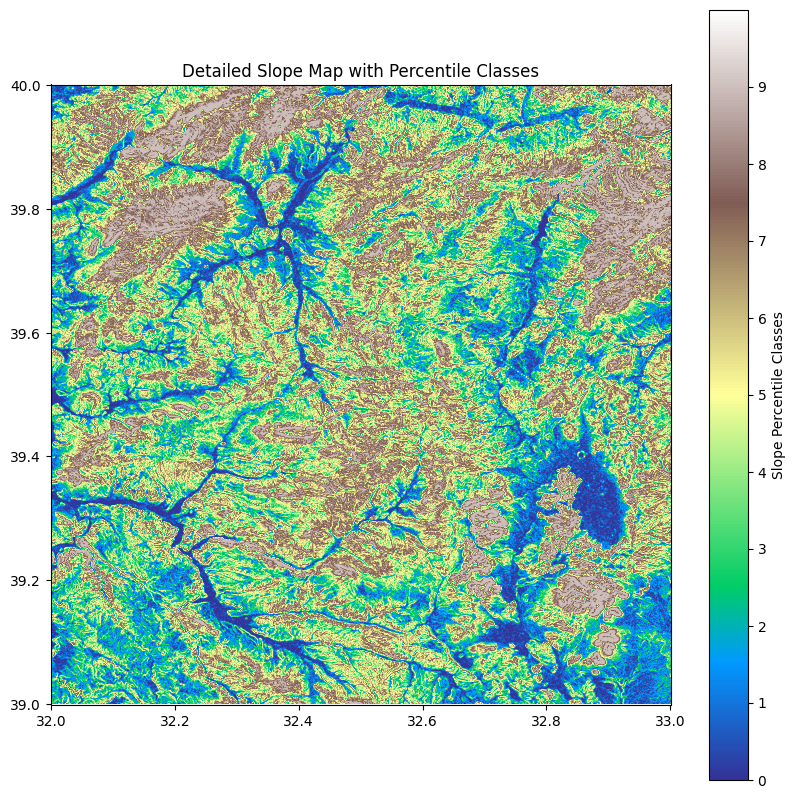

In [19]:
# Function to calculate slope with finer detail
def calculate_detailed_slope(data, transform):
    # Convert data to GPU array
    data_gpu = cp.asarray(data)
    
    # Get pixel size
    dx = transform[0]
    dy = transform[4]
    
    # Calculate gradients in x and y directions using central differences
    gradient_y, gradient_x = cp.gradient(data_gpu, dy, dx)
    
    # Calculate slope in degrees
    slope_gpu = cp.arctan(cp.sqrt(gradient_x**2 + gradient_y**2)) * (180 / cp.pi)
    
    # Transfer the result back to CPU
    return cp.asnumpy(slope_gpu)

# Function to classify the slope data into percentiles using CuPy
def classify_percentiles_gpu(data, num_classes=10):
    # Transfer data to GPU
    data_gpu = cp.asarray(data)
    
    # Compute percentiles on the GPU
    percentiles_gpu = cp.percentile(data_gpu, cp.linspace(0, 100, num_classes + 1))
    
    # Classify data based on percentiles
    classified_gpu = cp.digitize(data_gpu, percentiles_gpu) - 1
    
    # Transfer the result back to CPU
    return cp.asnumpy(classified_gpu)

# Using SRTM Void Filled 3arc, South-West Ankara - Coordinates: 39 , 32
# Data from https://earthexplorer.usgs.gov/
raster_file = 'n39_e032_3arc_v2.tif'

# Open the raster file
with rasterio.open(raster_file) as dataset:
    # Read the raster data as NumPy array
    raster_data = dataset.read(1)
    crs = dataset.crs
    transform = dataset.transform
    print(f'Coordinate Reference System: {crs}')
    print(f'Transform: {transform}')
    bounds = dataset.bounds
    print(f'Bounds: {bounds}')

# Calculate slope using GPU
slope_data = calculate_detailed_slope(raster_data, transform)

# Classify slope data into percentiles using GPU
classified_slope_data = classify_percentiles_gpu(slope_data)

# Plot the classified slope data
plt.figure(figsize=(10, 10))
plt.imshow(classified_slope_data, cmap='terrain', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.title('Detailed Slope Map with Percentile Classes')
plt.colorbar(ticks=range(10), label='Slope Percentile Classes')

plt.show()